# 目的

In [1]:
EXP_NAME = "e016_aug_team_1_and_2_2_and_1"

In [ ]:
import polars as pl
import pandas as pd
import numpy as np

# from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

import seaborn as sns

In [3]:
pl.__version__

'1.17.1'

In [4]:
lgb.__version__

'4.5.0'

In [5]:
train = pd.read_csv("../data/train.csv") 
test = pd.read_csv("../data/test.csv")
monster = pd.read_csv("../data/monster.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [6]:
test

,Team1,Team2
0,shu421 & YuYagi,kami & T88
1,shu421 & YuYagi,kami & RYUSHI
2,shu421 & YuYagi,kami & tattaka
3,shu421 & YuYagi,Kohecchi & T88
4,shu421 & YuYagi,Kohecchi & RYUSHI
...,...,...
6163,chumajin & NSK,Kinosuke & tattaka
6164,chumajin & NSK,K.T. & tattaka
6165,Kinosuke & K.T.,tattaka & NSK
6166,Kinosuke & tattaka,K.T. & NSK


In [7]:
train.head(100).to_csv("train_head_100.csv", index=False)

# 特徴量生成

In [8]:
train["Team1_1_member"] = train["Team1"].str.split(" & ").apply(lambda x: x[0])
train["Team1_2_member"] = train["Team1"].str.split(" & ").apply(lambda x: x[1])

train["Team2_1_member"] = train["Team2"].str.split(" & ").apply(lambda x: x[0])
train["Team2_2_member"] = train["Team2"].str.split(" & ").apply(lambda x: x[1])

test["Team1_1_member"] = test["Team1"].str.split(" & ").apply(lambda x: x[0])
test["Team1_2_member"] = test["Team1"].str.split(" & ").apply(lambda x: x[1])

test["Team2_1_member"] = test["Team2"].str.split(" & ").apply(lambda x: x[0])
test["Team2_2_member"] = test["Team2"].str.split(" & ").apply(lambda x: x[1])

# data augmentation

In [ ]:
train["group_id"] = train["Team1"] + "_" + train["Team2"]

In [9]:
train_team_aug_1 = train.copy()
train_team_aug_1["Team1_1_member"] = train["Team1_2_member"]
train_team_aug_1["Team1_2_member"] = train["Team1_1_member"]

train_team_aug_2 = train.copy()
train_team_aug_2["Team2_1_member"] = train["Team2_2_member"]
train_team_aug_2["Team2_2_member"] = train["Team2_1_member"]

train_team_aug_3 = train.copy()
train_team_aug_3["Team1_1_member"] = train["Team1_2_member"]
train_team_aug_3["Team1_2_member"] = train["Team1_1_member"]
train_team_aug_3["Team2_1_member"] = train["Team2_2_member"]
train_team_aug_3["Team2_2_member"] = train["Team2_1_member"]

In [10]:
train = pd.concat([
        train,
        train_team_aug_1,
        train_team_aug_2,
        train_team_aug_3
    ], axis=0).reset_index(drop=True)

In [11]:
train.shape

(21840, 27)

In [12]:
train = (
    train.merge(
        monster.add_suffix("_1_1"),
        how="left",
        left_on="Team1_1_member",
        right_on="monster_name_1_1"
    ).merge(
        monster.add_suffix("_1_2"),
        how="left",
        left_on="Team1_2_member",
        right_on="monster_name_1_2"
    ).merge(
        monster.add_suffix("_2_1"),
        how="left",
        left_on="Team2_1_member",
        right_on="monster_name_2_1"
    ).merge(
        monster.add_suffix("_2_2"),
        how="left",
        left_on="Team2_2_member",
        right_on="monster_name_2_2"
    )
)

In [13]:
test = (
    test.merge(
        monster.add_suffix("_1_1"),
        how="left",
        left_on="Team1_1_member",
        right_on="monster_name_1_1"
    ).merge(
        monster.add_suffix("_1_2"),
        how="left",
        left_on="Team1_2_member",
        right_on="monster_name_1_2"
    ).merge(
        monster.add_suffix("_2_1"),
        how="left",
        left_on="Team2_1_member",
        right_on="monster_name_2_1"
    ).merge(
        monster.add_suffix("_2_2"),
        how="left",
        left_on="Team2_2_member",
        right_on="monster_name_2_2"
    )
)

In [14]:
train.columns

Index(['Team1', 'Team2', 'Team1_win_ratio', 'battle1_winner', 'battle1_log',
       'battle2_winner', 'battle2_log', 'battle3_winner', 'battle3_log',
       'battle4_winner',
       ...
       'skill2_hitrate_2_2', 'skill2_attribute_2_2', 'skill2_attack_type_2_2',
       'skill2_status_effect_chance_2_2', 'skill3_name_2_2',
       'skill3_power_2_2', 'skill3_hitrate_2_2', 'skill3_attribute_2_2',
       'skill3_attack_type_2_2', 'skill3_status_effect_chance_2_2'],
      dtype='object', length=127)

In [15]:
# def sorted_team_1_member(row):
#     value = "__".join(sorted([row["Team1_1_member"], row["Team1_2_member"]]))
#     return value

# def sorted_team_2_member(row):
#     value = "__".join(sorted([row["Team2_1_member"], row["Team2_2_member"]]))
#     return value

# train["sorted_team_1_member"] = train.apply(lambda x :sorted_team_1_member(x), axis=1)
# train["sorted_team_2_member"] = train.apply(lambda x :sorted_team_2_member(x), axis=1)

# test["sorted_team_1_member"] = test.apply(lambda x :sorted_team_1_member(x), axis=1)
# test["sorted_team_2_member"] = test.apply(lambda x :sorted_team_2_member(x), axis=1)

In [16]:
train = pl.from_pandas(train)
test = pl.from_pandas(test)

In [17]:
USE_COL = ["Team1_1_member", "Team1_2_member", "Team2_1_member", "Team2_2_member"]
USE_COL += [col + "_1_1" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
USE_COL += [col + "_1_2" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
USE_COL += [col + "_2_1" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
USE_COL += [col + "_2_2" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
# USE_COL += ["sorted_team_1_member", "sorted_team_2_member"]

CATEGORICAL_FEATURE = [
    "Team1_1_member",
    "Team1_2_member",
    "Team2_1_member",
    "Team2_2_member",
    "monster_type_1_1",
    "monster_type_1_2",
    "monster_type_2_1",
    "monster_type_2_2",
    "skill1_attribute_1_1",
    "skill1_attribute_1_2",
    "skill1_attribute_2_1",
    "skill1_attribute_2_2",
    "skill2_attribute_1_1",
    "skill2_attribute_1_2",
    "skill2_attribute_2_1",
    "skill2_attribute_2_2",
    "skill3_attribute_1_1",
    "skill3_attribute_1_2",
    "skill3_attribute_2_1",
    "skill3_attribute_2_2",
    "skill1_name_1_1",
    "skill1_name_1_2",
    "skill1_name_2_1",
    "skill1_name_2_2",
    "skill1_attack_type_1_1",
    "skill1_attack_type_1_2",
    "skill1_attack_type_2_1",
    "skill1_attack_type_2_2",
    "skill2_name_1_1",
    "skill2_name_1_2",
    "skill2_name_2_1",
    "skill2_name_2_2",
    "skill2_attack_type_1_1",
    "skill2_attack_type_1_2",
    "skill2_attack_type_2_1",
    "skill2_attack_type_2_2",
    "skill3_name_1_1",
    "skill3_name_1_2",
    "skill3_name_2_1",
    "skill3_name_2_2",
    "skill3_attack_type_1_1",
    "skill3_attack_type_1_2",
    "skill3_attack_type_2_1",
    "skill3_attack_type_2_2",
    # "sorted_team_1_member",
    # "sorted_team_2_member"
]
TARGET_COL = "Team1_win_ratio"
FOLD_NUM = 5
SEED = 42

In [18]:
# Categorical型への変換
train = train.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))
test = test.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))

In [ ]:
# # Foldの作成
# fold_arr = np.zeros(train.height)
# fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

# for idx, (_, val_idx) in enumerate(fold.split(train)):
#     fold_arr[val_idx] = idx

# train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

# Foldの作成
fold_arr = np.zeros(train.height)
fold = GroupKFold(n_splits=FOLD_NUM)
# fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

for idx, (_, val_idx) in enumerate(fold.split(train, train[TARGET_COL], train["group_id"].to_list())):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

In [20]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": -1,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.01,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [21]:
# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL)
    X_valid = valid_fold.select(USE_COL)
    y_train = train_fold.select(TARGET_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train.to_pandas(), y_train.to_pandas())
    lgb_eval = lgb.Dataset(
        X_valid.to_pandas(), y_valid.to_pandas(), reference=lgb_train
    )

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=100
            ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
            lgb.log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
        ],
    )

    # モデルを保存
    models.append([fold, model])

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.207597	valid_1's rmse: 0.210524
[200]	training's rmse: 0.173333	valid_1's rmse: 0.177362
[300]	training's rmse: 0.159106	valid_1's rmse: 0.163941
[400]	training's rmse: 0.150859	valid_1's rmse: 0.156116
[500]	training's rmse: 0.144657	valid_1's rmse: 0.150428
[600]	training's rmse: 0.140431	valid_1's rmse: 0.146782
[700]	training's rmse: 0.137432	valid_1's rmse: 0.144436
[800]	training's rmse: 0.135053	valid_1's rmse: 0.14274
[900]	training's rmse: 0.133218	valid_1's rmse: 0.141634
[1000]	training's rmse: 0.131607	valid_1's rmse: 0.140763
[1100]	training's rmse: 0.130269	valid_1's rmse: 0.140077
[1200]	training's rmse: 0.129059	valid_1's rmse: 0.139619
[1300]	training's rmse: 0.128012	valid_1's rmse: 0.139307
[1400]	training's rmse: 0.127001	valid_1's rmse: 0.139026
[1500]	training's rmse: 0.126122	valid_1's rmse: 0.138855
[1600]	training's rmse: 0.125252	valid_1's rmse: 0.138633
[1700]	

In [22]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold, model in models:
    valid_fold = train.filter(pl.col("fold") == fold)

    X_valid = valid_fold.select(USE_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # validデータに対する推論
    y_valid_pred = model.predict(
        X_valid.to_pandas(), num_iteration=model.best_iteration
    )

    score = root_mean_squared_error(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    is_valid = train.get_column("fold") == fold
    oof[is_valid] = y_valid_pred

fold 0 Score: 0.1380146232812884
fold 1 Score: 0.13822732197544182
fold 2 Score: 0.1390202233023872
fold 3 Score: 0.14106058812399183
fold 4 Score: 0.136154240286659


In [23]:
oof_score = root_mean_squared_error(train.get_column(TARGET_COL), oof)
oof_score

0.1385045255123079

<Axes: >

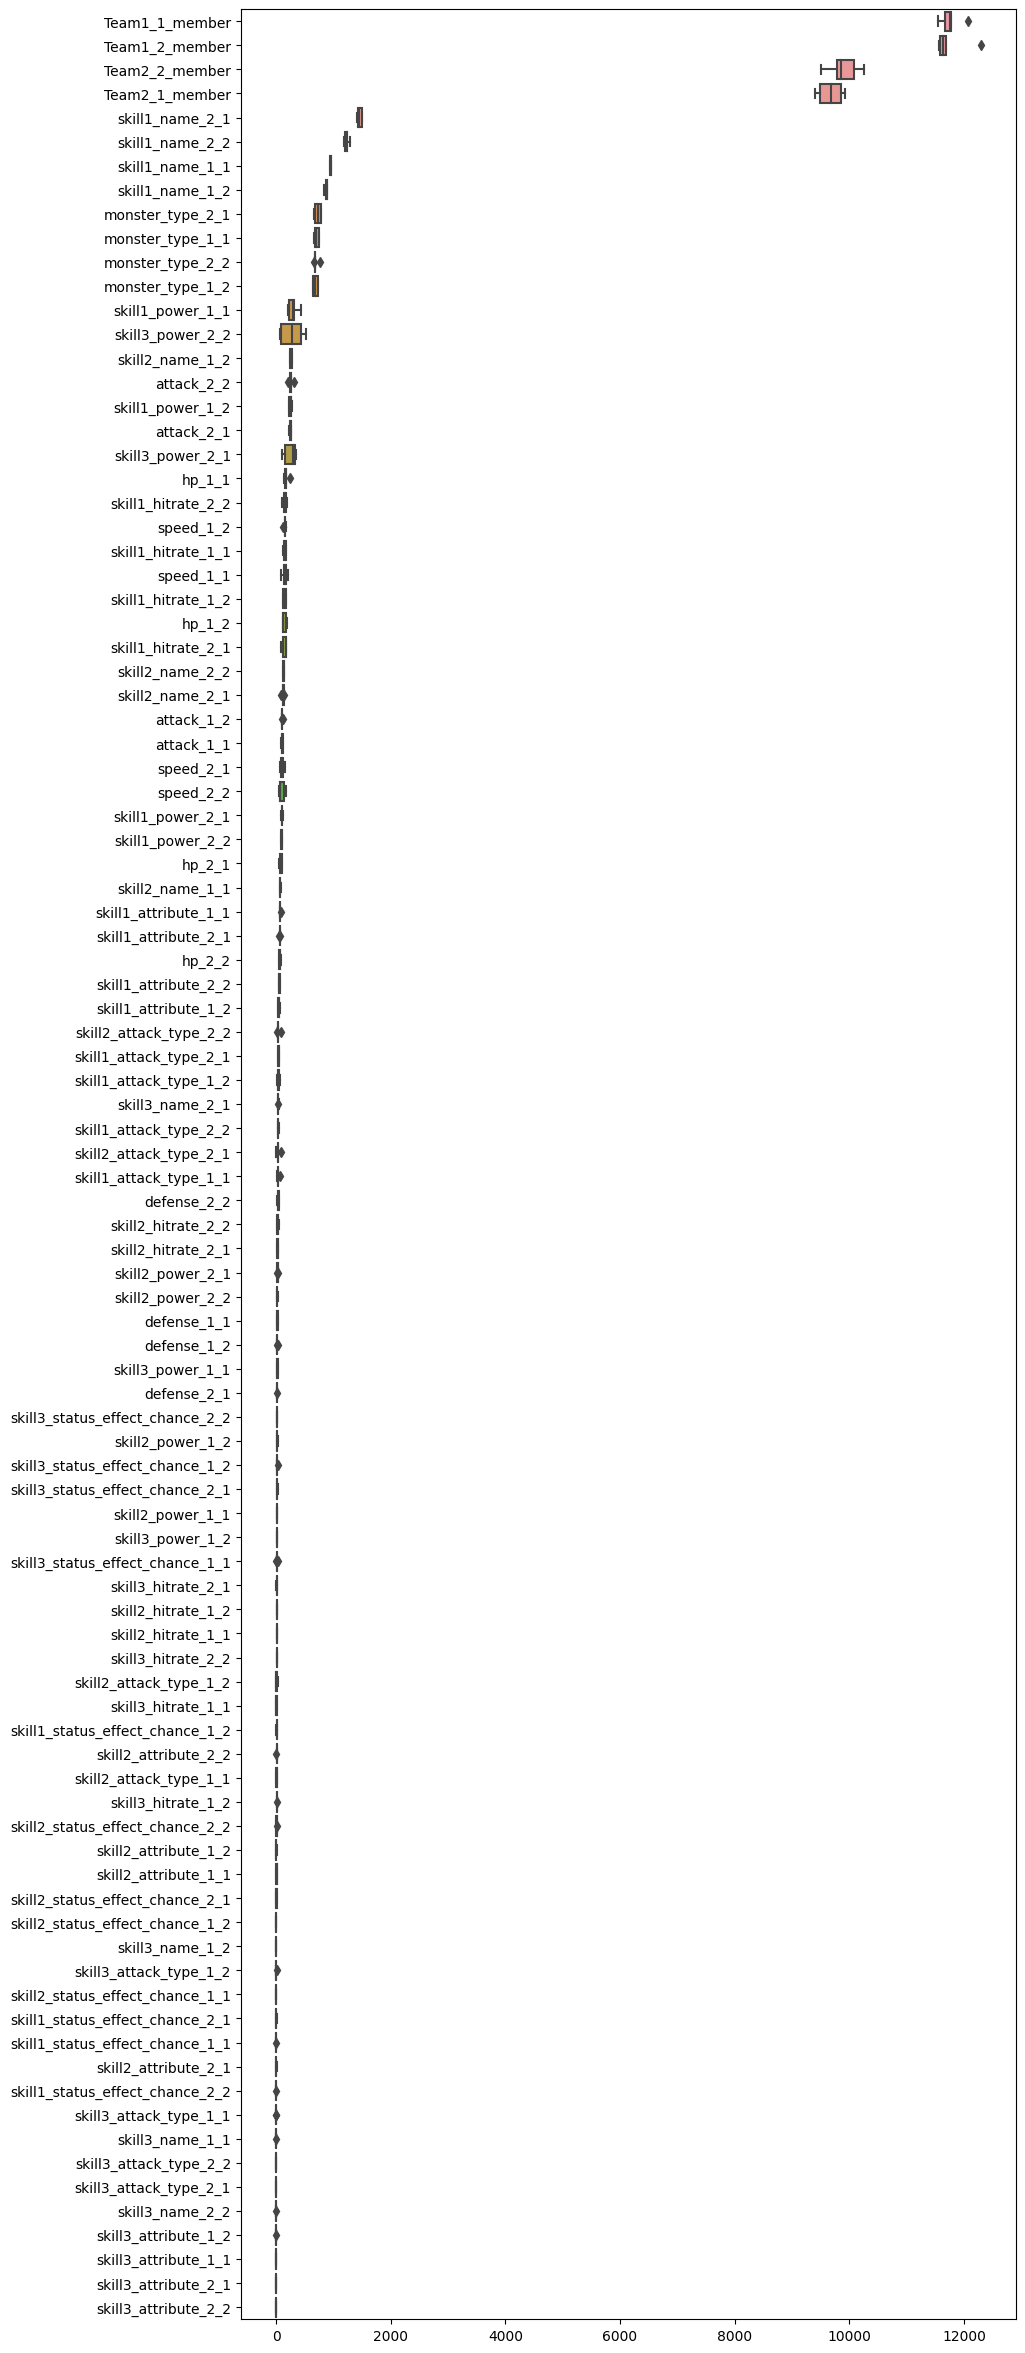

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = [
    model.feature_importance(importance_type="gain") for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()
plt.figure(figsize=(10, 30))
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [25]:
pred = np.array([model.predict(test[USE_COL].to_pandas()) for _, model in models])
pred = np.mean(pred, axis=0)
pred

array([0.75386599, 0.68598902, 0.78307795, ..., 0.2984878 , 0.06466116,
       0.60942013])

In [26]:
len(pred)

6168

In [27]:
sample_submission["Team1_win_ratio"] = pred
sample_submission.to_csv(f"../submission/{EXP_NAME}_CV{oof_score:.4f}.csv", index=False)

In [28]:
sample_submission

,Team1_win_ratio,Team1_Team2
0,0.753866,shu421 & YuYagi_kami & T88
1,0.685989,shu421 & YuYagi_kami & RYUSHI
2,0.783078,shu421 & YuYagi_kami & tattaka
3,0.526553,shu421 & YuYagi_Kohecchi & T88
4,0.473153,shu421 & YuYagi_Kohecchi & RYUSHI
...,...,...
6163,0.866505,chumajin & NSK_Kinosuke & tattaka
6164,0.665455,chumajin & NSK_K.T. & tattaka
6165,0.298488,Kinosuke & K.T._tattaka & NSK
6166,0.064661,Kinosuke & tattaka_K.T. & NSK
